# Ejercicio Ridge, Lasso y ElasticNet
Para este ejercicio vas a trabajar con datos de ventas de una empresa que fabrica muebles en España. Esta empresa es una Pyme que demanda conocer de antemano qué ingresos va a tener cada mes, ya que necesita pedir un anticipio a su entidad financiera de cara a poder abastecerse de materia prima al comenzar el mes. Como desconoce cuánto tiene que pedir, tira al alza y acaba pagando muchos intereses. El objetivo es reducir estos gastos.

En las bases de datos de la empresa constan todos los gastos en publicidad y ventas, para cada uno de los meses desde su fundación (hace más de 15 años).

Dado que los presupuestos de marketing se cierran al principio de cada mes, la empresa necesita un modelo predictivo que le anticipe las ventas que conseguirá a final de mes en función de los gastos que realizará en marketing.

Para ello tendrás que utilizar tanto modelos de regresión normales, como regularizados.

1. Carga los datos y realiza un pequeño análisis exploratorio. Mira a ver cómo se relaciona las ventas con el resto de variables.
2. Crea varios modelos y modifica los hiperparámetros necesarios para mejorar el performance del modelo.
3. Interpreta los resultados. Traduce a una fórmula tu mejor modelo (escribir la fórmula simplemente). ¿Cuánto cambian las ventas si aumentamos la inversión en radio un punto más? ¿Y si aumentamos la inversión en TV o periódicos?

## Import libraries 

In [151]:
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns


## Exploratory Data Analysis 

In [152]:
df = pd.read_csv('data/Advertising.csv')
df.head()

,Unnamed: 0,TV,radio,newpaper,sales
0,0,230.1,37.8,6s9.2,22100.0
1,1,44.5,39.3,45.1,10400.0
2,2,17.2,45.9,69.3,9300.0
3,3,151.5,41.3,58.5,18500.0
4,4,180.8,10.8,58.4,12900.0


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   radio       200 non-null    float64
 3   newpaper    200 non-null    object 
 4   sales       200 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.9+ KB


In [154]:
df.describe()

,Unnamed: 0,TV,radio,sales
count,200.000000,200.000000,200.000000,200.000000
mean,99.500000,147.042500,23.264000,14022.500000
std,57.879185,85.854236,14.846809,5217.456566
min,0.000000,0.700000,0.000000,1600.000000
25%,49.750000,74.375000,9.975000,10375.000000
50%,99.500000,149.750000,22.900000,12900.000000
75%,149.250000,218.825000,36.525000,17400.000000
max,199.000000,296.400000,49.600000,27000.000000


In [155]:
print(df.dtypes)


Unnamed: 0      int64
TV            float64
radio         float64
newpaper       object
sales         float64
dtype: object


In [156]:
df = df.reset_index(drop=True)

In [157]:
df['newpaper'] = pd.to_numeric(df['newpaper'], errors='coerce')

In [158]:
df = df.drop(columns=['Unnamed: 0'])

In [159]:
df.describe()

,TV,radio,newpaper,sales
count,200.000000,200.000000,199.000000,200.000000
mean,147.042500,23.264000,30.359799,14022.500000
std,85.854236,14.846809,21.659246,5217.456566
min,0.700000,0.000000,0.300000,1600.000000
25%,74.375000,9.975000,12.700000,10375.000000
50%,149.750000,22.900000,25.600000,12900.000000
75%,218.825000,36.525000,44.700000,17400.000000
max,296.400000,49.600000,114.000000,27000.000000


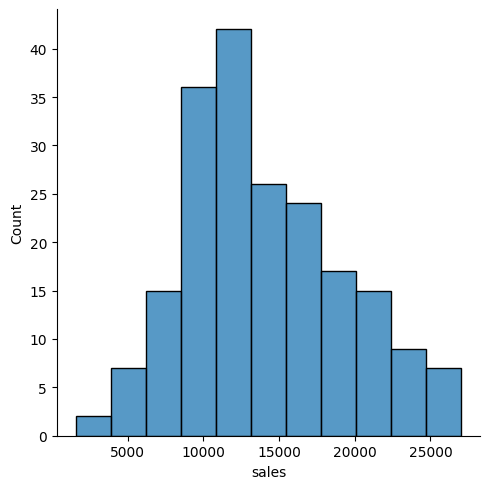

In [160]:
sns.displot(df['sales'])

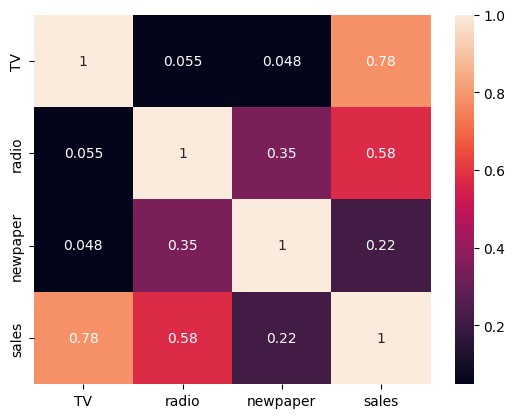

In [161]:
sns.heatmap(df.corr(numeric_only=True), annot=True);




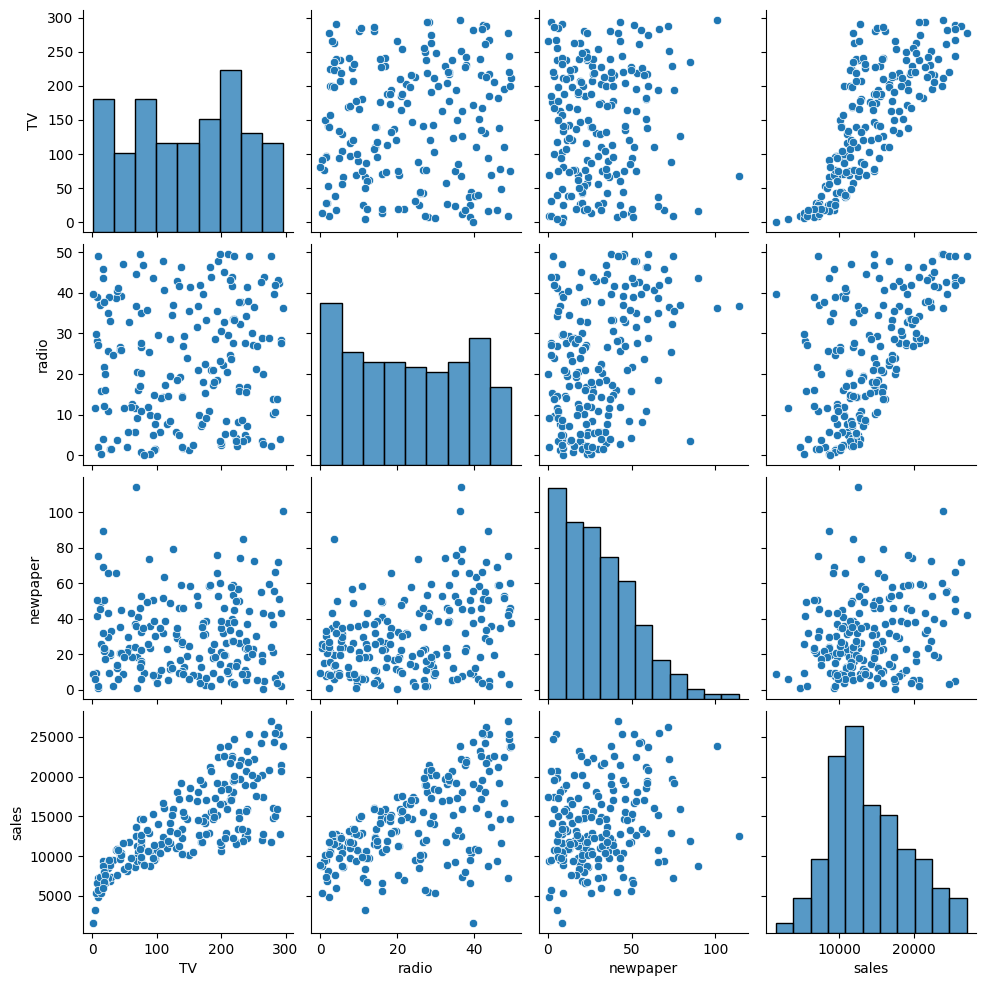

In [162]:
sns.pairplot(df)
plt.show();

## Modelado

In [188]:
# train : the first rows 
# test : the last rows 
n_split = 60
X_train = df.iloc[:n_split,0:-2] 
X_test = df.iloc[n_split:,0:-2]
y_train = df.iloc[:n_split,-1] 
y_test = df.iloc[n_split:,-1]  

In [189]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
# print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 2665370.5128121194
Test MSE: 2871057.572015196


In [190]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60, 2)
(140, 2)
(60,)
(140,)


In [192]:
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
baseline_error = metrics.mean_squared_error(y_test, y_pred)

print("Train MSE:", metrics.mean_squared_error(y_train, lr.predict(X_train)))
print("Test MSE:", metrics.mean_squared_error(y_test, lr.predict(X_test)))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, lr.predict(X_test))))

Train MSE: 2665370.5128121194
Test MSE: 2871057.572015196
Test RMSE: 1694.419538371532


In [193]:
from sklearn.linear_model import Ridge

ridgeR = Ridge(alpha = 0.001)
ridgeR.fit(X_train, y_train)

print("Train MSE sin regularización:", round(metrics.mean_squared_error(y_train, lr.predict(X_train)),2))
print("Test MSE sin regularización:", round(metrics.mean_squared_error(y_test, lr.predict(X_test)),2))

print("Train MSE con regularización:", round(metrics.mean_squared_error(y_train, ridgeR.predict(X_train)),2))
print("Test MSE con regularización:", round(metrics.mean_squared_error(y_test, ridgeR.predict(X_test)),2))
print("Test RMSE:", np.sqrt(metrics.mean_squared_error(y_test, ridgeR.predict(X_test))))

Train MSE sin regularización: 2665370.51
Test MSE sin regularización: 2871057.57
Train MSE con regularización: 2665370.51
Test MSE con regularización: 2871057.47
Test RMSE: 1694.4195082739075


# (Explicación contaminación entre train y test)

## Resultados